In [1]:
data_explanation = {"CHANNEL": "Channel used to send the packet",
"CODR" : "Coding rate packet",
"CREATED AT": "Timestamp indicating the time when the entry has been created inside the database",
"DATR" :"SF and bandwidth of the packet",
"DEV_ADDR" :"Unique identifier of the device inside the network",
"DEV_EUI" : "Unique identifier of the physical device (None if the device is unknown)",
"FREQUENCY" : "Frequency of the sent packet in MHz",
"GATEWAY" : "GW MAC ADDRESS which received the packet",
"LSNR" : "Received signal to noise ratio of the packet",
"FCNT" : "Frame counter: counter increasing for each packet sent from ED;used evaluate error rate",
"RSSI" : "Received packet signal strength",
"SIZE" : "Packet size (bytes)",
"CRC_STATUS" : "result: if 1 = passed if −1 = failed",
"TMST" : "Internal clock timestamp from gateway: used for synchronizing the downlink\
        with the end transmission of the uplink to communicate response to end-device",
"UID" : "Unique identifier of the entry inside the database}"}

In [57]:
import pandas as pd
from matplotlib import pyplot as plt
import math
import numpy as np
from scipy import optimize
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score

In [3]:
data = pd.read_csv("anonymized_spazio_radio_v2.csv")

In [4]:
def countna():
    nasdict = {}
    for i in data.columns:
        nasdict[i] = [('not na', data[i].notna().sum()),('na', data[i].isna().sum())]
    return nasdict

In [5]:
countna()

{'ant': [('not na', 186632), ('na', 0)],
 'chan': [('not na', 186632), ('na', 0)],
 'codr': [('not na', 186632), ('na', 0)],
 'created_at': [('not na', 186632), ('na', 0)],
 'datr': [('not na', 186632), ('na', 0)],
 'dev_addr': [('not na', 186632), ('na', 0)],
 'dev_eui': [('not na', 186632), ('na', 0)],
 'dev_nonce': [('not na', 5106), ('na', 181526)],
 'freq': [('not na', 186632), ('na', 0)],
 'gateway': [('not na', 186632), ('na', 0)],
 'lsnr': [('not na', 186632), ('na', 0)],
 'ns_time': [('not na', 186632), ('na', 0)],
 'rssi': [('not na', 181526), ('na', 5106)],
 'rssic': [('not na', 186632), ('na', 0)],
 'rssis': [('not na', 176025), ('na', 10607)],
 'rssisd': [('not na', 176025), ('na', 10607)],
 'size': [('not na', 186632), ('na', 0)],
 'time': [('not na', 186622), ('na', 10)],
 'tmms': [('not na', 186622), ('na', 10)],
 'tmst': [('not na', 186632), ('na', 0)],
 'FCnt': [('not na', 181526), ('na', 5106)],
 'valueRaw': [('not na', 186632), ('na', 0)],
 'value_minutes': [('not n

### It is noticable that the number of rows where rssi and rssic are different is the same number of rows of rssi Na

In [6]:
data.codr.unique() #codr has only one value across the data

array(['4/5'], dtype=object)

In [7]:
((data.loc[data['rssi'].notna(),['rssi']]).values ==\
 (data.loc[data['rssi'].notna(),['rssic']]).values).all()
#validating that rssi and rssic have equal values but rssic has no Na's so we drop rssi

True

In [8]:
len(data.dev_eui.unique()) == len(data.dev_addr.unique())

True

In [9]:
data = data.drop(columns = ['dev_nonce']) # has 181526 NA
data = data.drop(columns = ['codr']) #has only one value 
data = data.drop(columns = ['dev_eui']) #mapping one to one with dev_addr
data = data.drop(columns = ['ns_time']) #we drop ns_time because
        #the time of inserting the data inside the database is not relavant to our analysis
data = data.drop(columns = ['rssi']) #duplicated data from rssic
data = data.drop(columns = ['created_at','tmms','value_minutes','tmst',]) 
#duplicated and irrelevant timestamps

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186632 entries, 0 to 186631
Data columns (total 14 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   ant       186632 non-null  int64  
 1   chan      186632 non-null  int64  
 2   datr      186632 non-null  object 
 3   dev_addr  186632 non-null  object 
 4   freq      186632 non-null  float64
 5   gateway   186632 non-null  object 
 6   lsnr      186632 non-null  float64
 7   rssic     186632 non-null  int64  
 8   rssis     176025 non-null  float64
 9   rssisd    176025 non-null  float64
 10  size      186632 non-null  int64  
 11  time      186622 non-null  object 
 12  FCnt      181526 non-null  float64
 13  valueRaw  186632 non-null  int64  
dtypes: float64(5), int64(5), object(4)
memory usage: 19.9+ MB


In [11]:
data['time'] = pd.to_datetime(data['time'])
data['time'] = data['time'].dt.tz_convert(None)

In [15]:
data.time = data.time.values.astype(np.int64) // 10 ** 9   #convert time to unix timestamp

In [20]:
data = data.dropna()

In [34]:
len(data)

171208

In [35]:
categorical = ['datr','dev_addr','gateway','chan','ant','freq']

In [36]:
datadum = pd.get_dummies(data, columns = categorical)

In [37]:
X = datadum.iloc[:,:].values

In [38]:
X.shape

(171208, 317)

In [55]:
wcss=[]
dbs=[]
for i in range(2,11): 
    kmeans = KMeans(n_clusters=i, init ='k-means++', max_iter=300,\
                    n_init=10,random_state=0,n_jobs=6 ).fit(X)
#inertia_ : Sum of squared distances of samples to their closest cluster center.
    wcss.append(kmeans.inertia_)
    labels = kmeans.labels_
    dbs.append(davies_bouldin_score(X, labels))
    print('clustering with k = {} done!'.format(i))

clustering with k = 2 done!
clustering with k = 3 done!
clustering with k = 4 done!
clustering with k = 5 done!
clustering with k = 6 done!
clustering with k = 7 done!
clustering with k = 8 done!
clustering with k = 9 done!
clustering with k = 10 done!


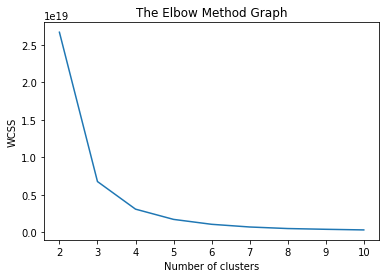

In [59]:
plt.plot(range(2,11),wcss)
plt.title('The Elbow Method Graph')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

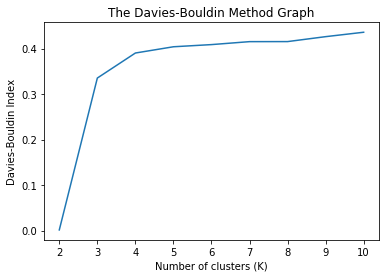

In [61]:
#Plot the Davies-Bouldin graph
plt.plot(range(2,11),dbs)
plt.title('The Davies-Bouldin Method Graph')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Davies-Bouldin Index')
plt.show

In [27]:
from matplotlib import pyplot as plt

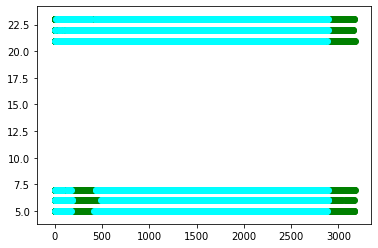

In [42]:
plt.scatter(data[labels==0]['FCnt'],data[labels==0]['chan'], c='blue', label ='Cluster 2')
plt.scatter(data[labels==1]['FCnt'],data[labels==1]['chan'], c='green', label ='Cluster 3')
plt.scatter(data[labels==2]['FCnt'],data[labels==2]['chan'], c='cyan', label ='Cluster 4')
plt.scatter(data[labels==3]['FCnt'],data[labels==3]['chan'],  c='magenta', label ='Cluster 5')
plt.scatter(data[labels==4]['FCnt'],data[labels==4]['chan'], c='cyan', label ='Cluster 4')
plt.scatter(data[labels==5]['FCnt'],data[labels==5]['chan'], c='magenta', label ='Cluster 5')
plt.scatter(data[labels==6]['FCnt'],data[labels==6]['chan'], c='cyan', label ='Cluster 4')

(array([0.00823024, 0.01481089, 0.01596827, 0.02530712, 0.0470002 ,
        0.04828174, 0.04396707, 0.01896149, 0.01480646, 0.01907678]),
 array([-24. , -20.1, -16.2, -12.3,  -8.4,  -4.5,  -0.6,   3.3,   7.2,
         11.1,  15. ]),
 <a list of 10 Patch objects>)

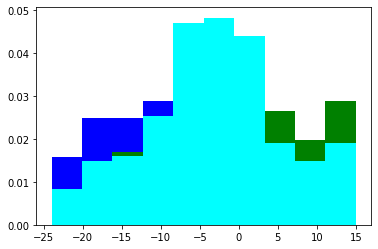

In [44]:
plt.hist(data[labels==0]['lsnr'],density=True, color='blue', label ='Cluster 0')
plt.hist(data[labels==1]['lsnr'],density=True, color='green', label ='Cluster 1')
plt.hist(data[labels==2]['lsnr'],density=True, color='cyan', label ='Cluster 2')


In [69]:
import seaborn as sns

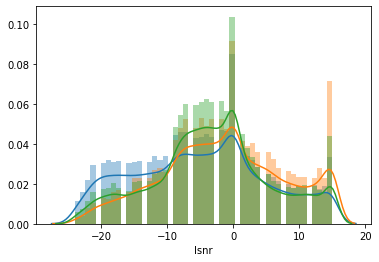

In [76]:
for i in np.unique(labels):
    sns.distplot(data[labels == i]['lsnr'])

In [77]:
from sklearn.cluster import DBSCAN

In [94]:
dbmodel = DBSCAN(eps=5,min_samples = 10, n_jobs=6)

In [95]:
newmod = dbmodel.fit_predict(datadum)

In [98]:
from sklearn.preprocessing import normalize

In [97]:
datadum

array([-1], dtype=int64)